In [1]:
 # ## 1. Import Required Libraries
import random
from math import gcd

# ## 2. Extended Euclidean Algorithm for Modular Inverse
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(e, phi):
    g, x, _ = egcd(e, phi)
    if g != 1:
        raise Exception('Modular inverse does not exist')
    else:
        return x % phi

# ## 3. Prime Number Generation (for simplicity using small primes)
# NOTE: For real RSA use, use cryptographic libraries for secure primes.
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def generate_prime_candidate(start=100, end=300):
    while True:
        p = random.randint(start, end)
        if is_prime(p):
            return p

# ## 4. RSA Key Generation
def generate_keys():
    p = generate_prime_candidate()
    q = generate_prime_candidate()
    while q == p:
        q = generate_prime_candidate()

    n = p * q
    phi = (p - 1) * (q - 1)

    e = 65537
    if gcd(e, phi) != 1:
        # fallback if 65537 not suitable
        e = 3
        while gcd(e, phi) != 1:
            e += 2

    d = modinv(e, phi)
    return ((e, n), (d, n), p, q)

# ## 5. Encryption and Decryption
def encrypt(message, pub_key):
    e, n = pub_key
    return pow(message, e, n)

def decrypt(ciphertext, priv_key):
    d, n = priv_key
    return pow(ciphertext, d, n)

# ## 6. Demo Execution
public_key, private_key, p, q = generate_keys()

print("Public Key:", public_key)
print("Private Key:", private_key)
print("Primes used (for educational purposes):", p, q)

# Convert message to integer (simple case)
message = 42
print("Original message:", message)

cipher = encrypt(message, public_key)
print("Encrypted message:", cipher)

decrypted = decrypt(cipher, private_key)
print("Decrypted message:", decrypted)

assert message == decrypted, "Decryption failed: the original and decrypted messages do not match."

# You can experiment with other message values < n



Public Key: (65537, 45173)
Private Key: (37817, 45173)
Primes used (for educational purposes): 227 199
Original message: 42
Encrypted message: 37521
Decrypted message: 42


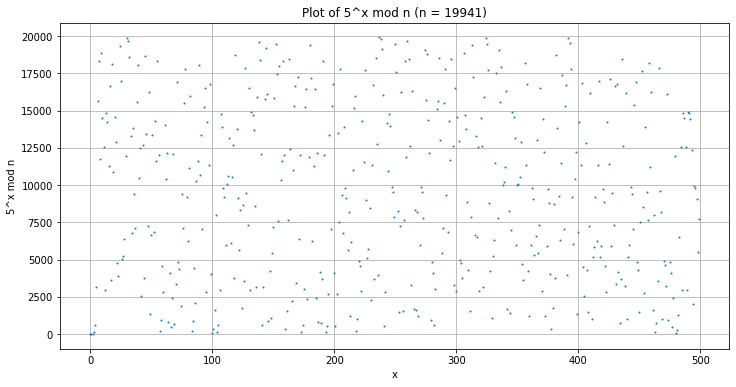

In [2]:
# ## 8. Plot a^x mod n to illustrate discrete logarithm hardness
import matplotlib.pyplot as plt

n=23*51*17
base = 5  # You can change this to another base (e.g., 2, 3, 7)
X = list(range(0, 500))
Y = [pow(base, x, n) for x in X]

plt.figure(figsize=(12, 6))
plt.plot(X, Y, '.', markersize=2)
plt.title(f"Plot of {base}^x mod n (n = {n})")
plt.xlabel("x")
plt.ylabel(f"{base}^x mod n")
plt.grid(True)
plt.show()


<strong> Why You Can’t Just Encrypt Arbitrarily Large Data?: 
RSA can only encrypt messages smaller than n. </strong>

If your message is larger:

You must split it into blocks smaller than  n.

Or better: use RSA to encrypt a symmetric key (like AES), and then encrypt the actual data with that key (hybrid encryption).

In [3]:
pip install rsa

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [4]:
import rsa

# Key generation
public_key, private_key = rsa.newkeys(2048)

print(public_key) # This outputs: n, e

print(private_key)  # This outputs: n, e, d, p, q


# n = modulus, public.

# e = public exponent, public.

# d = private exponent, secret.

# p, q = prime factors, secret.

# So the public key is simply (n, e).
# The private key is (n, d, p, q) 


# Message
message = b"A un amigo perdido"

# Encryption
ciphertext = rsa.encrypt(message, public_key)

# Decryption
plaintext = rsa.decrypt(ciphertext, private_key)

print("Original:", message)
print("Encrypted:", ciphertext)
print("Decrypted:", plaintext)


PublicKey(16413269694916736994772812151042794012224251447344332662383963513896046487099031995840003432798033374836714782992171909474465551504040620117222703153822112271346925218742470922440169005430126878899442203745810435469718227260353436783380341109013314658927393412880300368260093634490800506022275310716005392252192873133824489984660830500540182094894992799943339564882688548563610436123069973332957046538043863220024517582099777281538547080957139738715747317461372423619048806972489116393103266600603459518034938442046851106827872769636718240619398464741100877386571622369043815171619435545790886739337868763348680698477, 65537)
PrivateKey(16413269694916736994772812151042794012224251447344332662383963513896046487099031995840003432798033374836714782992171909474465551504040620117222703153822112271346925218742470922440169005430126878899442203745810435469718227260353436783380341109013314658927393412880300368260093634490800506022275310716005392252192873133824489984660830500540182094894992799

#  RSA Cannot Encrypt Arbitrarily Long Messages

RSA is built on number theory:  

- Two large primes $p, q$ are generated.  
- Compute $n = p \cdot q$, the **modulus**.  
- Encryption works as:
  $$ c \equiv m^e \pmod{n}$$
  where $m$ is the message (treated as a big integer).  

Thus, **$m < n$ ** must hold.  

- If $n$ is 2048 bits, the maximum $m$ is $2^{2048}-1$.  
- With padding (PKCS#1, OAEP), the usable message size is **≈245 bytes** for a 2048-bit modulus.  

Therefore, **RSA cannot directly encrypt large files or long messages**.

---

# Why Not Just Make RSA Bigger?

- RSA is **slow**: exponentiation with very large numbers.  
- RSA ciphertexts are as large as the modulus.  
- Unsafe without padding.  

Thus, RSA is only used for encrypting **short values** (keys, hashes).

---

# Hybrid Encryption (RSA + AES)

To handle long data, we combine RSA with a **symmetric cipher** (AES, ChaCha20):

1. **Generate a random AES key** (e.g., 256-bit).  
2. **Encrypt the actual message with AES** (works for any size).  
3. **Encrypt the AES key with RSA**:  
   $$ c_{\text{key}} = {\rm RSA\_Encrypt}(K)$$  
4. **Send:**  
   - The RSA-encrypted AES key.  
   - The AES ciphertext.  
5. **Receiver:**  
   - Decrypts AES key using RSA private key.  
   - Uses AES key to decrypt the message.  

This is how **TLS/HTTPS, PGP, SSH, Signal** work in practice.




In [5]:
import  os
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

# RSA keys
public_key, private_key = rsa.newkeys(2048)

# Large message (longer than RSA can handle)
message = b"A" * 5000  

# --- Hybrid Encryption ---
# 1. Generate AES key
aes_key = os.urandom(32)  # 256-bit AES

# 2. Encrypt message with AES
cipher_aes = AES.new(aes_key, AES.MODE_CBC)
ciphertext = cipher_aes.encrypt(pad(message, AES.block_size))

# 3. Encrypt AES key with RSA
enc_aes_key = rsa.encrypt(aes_key, public_key)

# Send/store enc_aes_key, cipher_aes.iv, ciphertext
package = (enc_aes_key, cipher_aes.iv, ciphertext)

# --- Hybrid Decryption ---
enc_aes_key, iv, ciphertext = package

# 1. Decrypt AES key with RSA
aes_key = rsa.decrypt(enc_aes_key, private_key)

# 2. Decrypt message with AES
cipher_aes = AES.new(aes_key, AES.MODE_CBC, iv=iv)
plaintext = unpad(cipher_aes.decrypt(ciphertext), AES.block_size)

print("Decrypted matches original:", plaintext == message)


Decrypted matches original: True
